In [2]:
import tensorflow as tf

# 0 、文件位置

In [3]:
trainset_path = "./image/train"
testset_path = "./image/test"
output_path = "./output"
image_width = 256
image_height = 256
image_channels = 3

# 一、创建 TFRecords文件

In [4]:
import glob
import os
from itertools import groupby
from scipy import misc
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

In [5]:
# class 信息
breeds_with_path = glob.glob(trainset_path + "/*")
breeds = list(map(lambda x:x.split("/")[3],breeds_with_path))
breeds_dict = dict(zip(breeds, [x for x in range(len(breeds))]))

In [6]:
print(breeds_dict["cat"])
print(breeds_dict["bird"])
print(breeds_dict["dog"])

1
2
0


In [7]:
def create_record(dataset_path,output_location):
    # 获取数据集下所有文件路径
    dataset_files = glob.glob(dataset_path + "/*/*.jpg")
    # 分离出claess信息,得到（class,file_path）对的列表
    image_filepath_with_breed = list(map(lambda file_path:(file_path.split("/")[3],file_path),dataset_files))
    
    #每个TFRecord文件保存10个图片
    nums_per_file = 10
    writer = None
    
    # 记录当前读到的图像index
    current_index = 0
    for breed, file_path in image_filepath_with_breed:
        if current_index % nums_per_file == 0:
            if writer:
                print("current_index = ",current_index,"\n")
                writer.close()
            
            # 格式化字符串
            record_filename = "{output_location}{current_index}.tfrecords".format(
            output_location = output_location,
            current_index = current_index)
            
            writer = tf.python_io.TFRecordWriter(record_filename)
            
        current_index += 1
        
        # 读取图像并转换为tf.example格式
        image = misc.imread(file_path)
            
        # 图像转换为Byte型
        image_raw = image.tobytes()
        
        example = tf.train.Example(features = 
                                  tf.train.Features(feature = {
                    "label": tf.train.Feature(int64_list = tf.train.Int64List(value = [breeds_dict[breed]])),
                    "image_raw": tf.train.Feature(bytes_list = tf.train.BytesList(value = [image_raw]))   
                }     
            )    
        )
        
        # 写入文件
        writer.write(example.SerializeToString())
        
    # 关闭最后一个文件
    writer.close()

In [8]:
#create_record(trainset_path,output_path + "/training-images/")
#create_record(testset_path,output_path + "/testing-images/")
print("\n")

# 二、 读取TFRecord 文件

In [50]:
filenames =tf.train.match_filenames_once(output_path + "/training-images/*.tfrecords")
#["/home/lile/ML_learning/ML_framework/output/training-images/10.tfrecords","/home/lile/ML_learning/ML_framework/output/training-images/0.tfrecords"] #
filenames_queue = tf.train.string_input_producer(filenames, shuffle = True)

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filenames_queue)
features = tf.parse_single_example(
    serialized_example,
    features = {
        "label":tf.FixedLenFeature([],tf.int64),
        "image_raw":tf.FixedLenFeature([],tf.string)
    }
)

# 解码图像数据
im = tf.decode_raw(features["image_raw"],tf.uint8)
#im1 = 
image = tf.reshape(im,(image_height,image_width,image_channels))
label = tf.cast(features["label"],tf.int32)

# 组合训练数据
batch_size = 3
capacity = 1000 + 3*batch_size
min_after_dequeue = 10*batch_size
image_batch, label_batch = tf.train.shuffle_batch_join(
[(image,label)],batch_size = batch_size,
capacity = capacity,min_after_dequeue = min_after_dequeue
)
init = [tf.global_variables_initializer(),tf.local_variables_initializer()]

# 三、定义网络模型

In [ ]:
# 输入层
x = tf.placeholder(tf.float32,shape = None)


# 运行

In [ ]:
with tf.Session() as sess:
    #在迭代控制中,记得添加tf.initialize_local_variables(),官网教程没有说明,但是如
    sess.run(init)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess = sess, coord = coord)
    
    #y1,y2 = sess.run([image_batch, label_batch])
    
    
    coord.request_stop()
    coord.join(threads)

(3, 256, 256, 3)


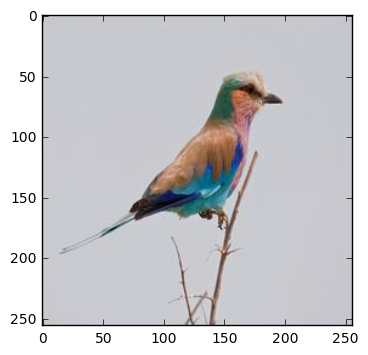

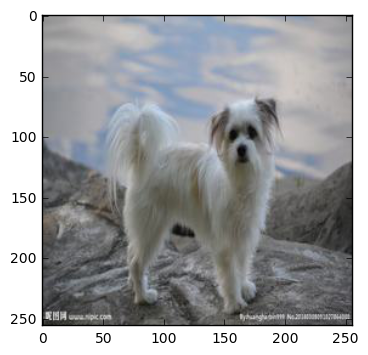

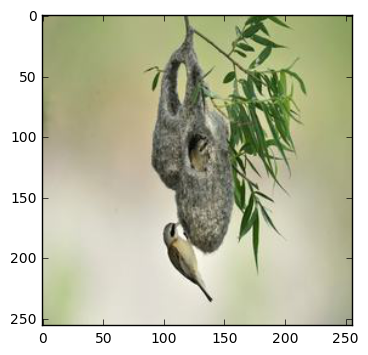

In [51]:
print(y1.shape)
plt.figure(0)
plt.imshow(y1[0])
plt.figure(1)
plt.imshow(y1[1])
plt.figure(2)
plt.imshow(y1[2])
pl.show()
